### 4. Weak Instruments

(1) Construct a data-generating process dgp which takes as arguments (n, β, π) and returns a triple (y, x, Z) of n observations.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t
import matplotlib.pyplot as plt 

def dgp(n, beta, pi):
    # Generate Z based on l (length of coefficient vector inputted for pi)
    l = len(pi)
    Z = np.random.randn(n, l)
    
    # Generate v (error term regressing x on Z)
    v = np.random.randn(n)
    
    # Generate x
    x = Z.dot(pi) + v
    
    # Generate u (error term for y)
    u = np.random.randn(n)
    
    # Generate y
    y = beta * x + u
    
    return y, x, Z

(2) Use the dgp function you’ve constructed to explore IV (2SLS) estimates of β as a function of π when l = 1 using a Monte Carlo approach, assuming homoskedastic errors.

In [5]:
# Run dgp function to test
y, x, Z = dgp(1000, 2, np.array([0.75]))

# Print the shapes of generated arrays
print("Shape of y:", y.shape)
print("Shape of x:", x.shape)
print("Shape of Z:", Z.shape)

Shape of y: (1000,)
Shape of x: (1000,)
Shape of Z: (1000, 1)


(a) Write a function two_sls which takes as arguments (y, x, Z) and returns two-stage least squares estimates of β and the standard error of the estimate.

In [6]:
def two_sls(y, x, Z):
    # First stage regression
    first_stage_model = sm.OLS(x, Z).fit()
    # Store fitted values
    x_hat = first_stage_model.predict()

    # Second stage regression
    second_stage_model = sm.OLS(y, sm.add_constant(x_hat)).fit()

    # Pull coefficient estimate of beta hat and standard error
    beta_hat = second_stage_model.params[1]
    se = second_stage_model.bse[1]

    return beta_hat, se

# Set the seed for reproducibility
np.random.seed(1)

# Example usage
beta_hat, se = two_sls(y, x, Z)

# Print estimated coefficient and standard error
print("Estimated coefficient (beta_hat):", beta_hat)
print("Standard error of the estimate (SE):", se)

# note that SEs are off -->estimated thing rather observed variable --> 
# blows up SEs 

Estimated coefficient (beta_hat): 2.0326869702886734
Standard error of the estimate (SE): 0.10120952935421171


b) Taking β = π = 1, use repeated draws from dgp to check the bias, and precision of the two_sls estimator, as well as the size and power of a t-test of the hypothesis that β = 0. Discuss. Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

In [11]:
def monte_carlo_simulation(n_simulations, n, beta, pi):
    # Store draws in results list
    results = []
    for i in range(n_simulations):
        # Run simulation
        y, x, Z = dgp(n, beta, pi)
        
        # Pull beta_hat and se for each draw
        beta_hat, se = two_sls(y, x, Z)
        
        # calculate t-stat and p-value
        t_stat = (beta_hat - 0) / se
        p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-2))
        # reject_null = p_value < 0.05
        reject_null = 1 if p_value < 0.05 else 0
        results.append({'beta_hat': beta_hat, 'se': se, 't-stat': t_stat,
                        'p-value': p_value, 'reject_null': reject_null})
        
    return pd.DataFrame(results)

# Define Parameters
# Re-run dgp function assuming β = π = 1
n_simulations = 1000
n = 1000
beta = 1
pi = np.array([1])

# Set the seed for reproducibility
np.random.seed(1)

# Run Monte Carlo simulation
simulation_results = monte_carlo_simulation(n_simulations, n, beta, pi)

In [12]:
# Calculate bias and precision of 2SLS estimator
# bias: E[beta_hat] - beta 
bias = simulation_results['beta_hat'].mean() - beta
# precision: sqrt [var(beta_hat)/n]
precision = simulation_results['beta_hat'].std()/np.sqrt(len(simulation_results['beta_hat']))

# Calculate size and power of t-test
size = simulation_results['reject_null'].mean()
power = 1 - size

# todo: check , maybe it rounds?

In [13]:
# Calculate coverage probability of 95% confidence interval
ci_coverage = simulation_results[(simulation_results['beta_hat'] - 1.96 * simulation_results['se'] < beta) &
                                  (simulation_results['beta_hat'] + 1.96 * simulation_results['se'] > beta)].shape[0] / n_simulations


In [15]:
print("Bias of 2SLS estimator:", bias)
print("Precision of 2SLS estimator:", precision)
print("Size of t-test:", size)
print("Power of t-test:", power)
print("Coverage probability of 95% CI:", ci_coverage)

Bias of 2SLS estimator: -0.0013769816865324414
Precision of 2SLS estimator: 0.000989867802182021
Size of t-test: 1.0
Power of t-test: 0.0
Coverage probability of 95% CI: 0.994


We observe very low bias, suggesting that the estimator is performing well in estimating the true parameter value. 

As we find above, weak instruments can lead to overstatement of the significance of estimated effects. Despite the inflated SEs, the t-statistics may still suggest statistical significance due to the large sample size. 

Yes, the 95% confidence intervals constructed from the 2SLS estimator cover over 95% of my Monte Carlo draws.

(c) Taking β = 1, but allowing π ∈ [0, 1] again evaluate the bias and precision of the estimator, and the size and power of a t-test. The Z instrument is “weak” when π is “close” to zero. Comment on how a weak instrument affects two- stage least squares estimators.

In [31]:
# Re-Define Parameters
# Re-run dgp function assuming β = 1 and allowing π ∈ [0, 1]
# For each draw the value of pi is different?
n_simulations = 1000
n = 1000
beta = 1
# Create random value in between 0 and 1 
pi = np.array([np.random.uniform(0, 1)])

# Set the seed for reproducibility
np.random.seed(1)

print("Random value of pi between 0 and 1 (as array):", pi)

Random value of pi between 0 and 1 (as array): [0.26143982]


In [32]:
# Run Monte Carlo simulation
simulation_results = monte_carlo_simulation(n_simulations, n, beta, pi)

# Calculate bias and precision of 2SLS estimator
# bias: E[beta_hat] - beta 
bias = simulation_results['beta_hat'].mean() - beta
# precision: sqrt [var(beta_hat)/n]
precision = simulation_results['beta_hat'].std()/np.sqrt(len(simulation_results['beta_hat']))

# Calculate size and power of t-test
size = simulation_results['reject_null'].mean()
power = 1 - size

print("Bias of 2SLS estimator:", bias)
print("Precision of 2SLS estimator:", precision)
print("Size of t-test:", size)
print("Power of t-test:", power)

TypeError: only integer scalar arrays can be converted to a scalar index

When pi is "close" to zero, Z is considered a weak instrument. This can lead to biased inference in undrstanding the relationship between x and y through inflated standard errors.

In [33]:
def monte_carlo_simulation(n_simulations, n, beta, pi_range):
    results = []
    for pi_value in pi_range:
        pi = np.array([pi_value])
        for _ in range(n_simulations):
            y, x, Z = dgp(n, beta, pi)
            beta_hat, se = two_sls(y, x, Z)
            t_stat = (beta_hat - 0) / se
            p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-2))
            reject_null = 1 if p_value < 0.05 else 0
            results.append({'pi': pi_value, 'beta_hat': beta_hat})
    return pd.DataFrame(results)

# Parameters
n_simulations = 1000
n = 1000
beta = 1
pi_range = np.random.uniform(0, 1, size=1000)  # Generating 1000 random values for pi

# Run the simulation
simulation_results = monte_carlo_simulation(n_simulations, n, beta, pi_range)

TypeError: only integer scalar arrays can be converted to a scalar index

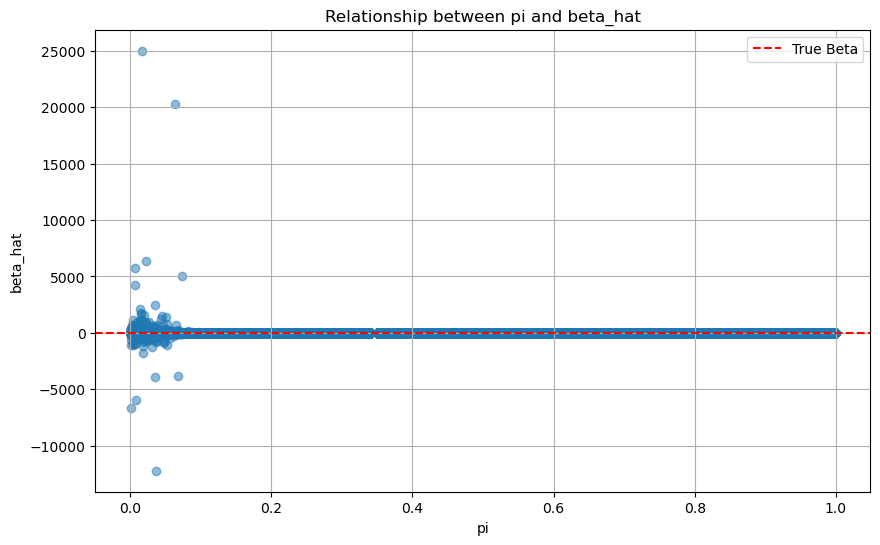

In [34]:
import matplotlib.pyplot as plt 

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(simulation_results['pi'], simulation_results['beta_hat'], alpha=0.5)
plt.axhline(y=beta, color='r', linestyle='--', label='True Beta')
plt.xlabel('pi')
plt.ylabel('beta_hat')
plt.title('Relationship between pi and beta_hat')
plt.legend()
plt.grid(True)
plt.show()

(3) Now consider another “weak” instruments problem. Consider the sequence {1,1/2,1/4,1/8,...}. Let l = 1,2,3,..., and for a particular value of l let the vector of parameters πl consist of the first l elements of the sequence. Thus, your dgp should now return Z we can treat as an n × l matrix, with successive columns of Z increasingly “weak” instruments.

In [1]:
l = 5
sequence = np.array([1 / 2**i for i in range(l)])
sequence

NameError: name 'np' is not defined

In [3]:
def dgp(n, beta, l):
    # Define the sequence
    sequence = np.array([1 / (2**i) for i in range(1, l + 1)])
    
    # Generate Z based on the input l / sequence denoted above
    Z = np.zeros((n, l))
    
    for i in range(l):
        Z[:, i] = np.random.randn(n) * sequence[i]
    
    # Generate v (error term regressing x on Z)
    v = np.random.randn(n)
    
    # Generate x
    x = Z.sum(axis=1) + v
    
    # Generate u (error term for y)
    u = np.random.randn(n)
    
    # Generate y
    y = beta * x + u
    
    return y, x, Z

In [4]:
# Example usage:
n = 1000
beta = 2
l = 10 
y, x, Z = dgp(n, beta, l)